<a href="https://colab.research.google.com/github/JimenaBaripatti/FeatureEngineering/blob/main/Fire_High_Cardinality_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To review/impute/FE Categorical variables with high cardinality

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# setting up libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import statistics
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency
import math
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline


# Setting working directory
#os.chdir("/content/drive/MyDrive/Colab Notebooks/Data/")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [4]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 315 kB/s 


# Functions

In [5]:
# extract categorical vs. numerical columns
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [6]:
# explore different variables
def exploration_cat(c):

  print('---------------------------------------')

  print('variable name:', c, '\n')
  print('number of categories: ' ,df[c].unique().shape[0], '\n')
  print(df[c].value_counts(normalize=True, dropna=False))

  print('---------------------------------------')

In [7]:
# plot categorical variables
def plot_cat(c):
  plt.figure(figsize=(20,7))
  cat_count=df[c].value_counts(normalize=True, dropna=False)
  fig=sns.barplot(100*cat_count.values[0:11], cat_count.index[0:11], alpha=0.9)
  plt.title('Frequency Distribution of ' + str(c))
  plt.xlabel('% occurences', fontsize=12)
  #fig.set_yticklabels(fig.get_yticklabels(),rotation=45, horizontalalignment='right')
  plt.show()


In [8]:
# frequency encoding
def freq_encode(c):
  freq_count=df[c].value_counts(normalize=True).to_dict()
  c_imputed=str(c)+'_imputed'
  df[c_imputed]=df[c].map(freq_count)
  return df

In [9]:
# Impute with the most frequent category
def impute_frequent (c):
  top_cat=df[c].value_counts().nlargest(1).index[0]
  index_to_impute=df[df[c].isnull()].index
  df.at[index_to_impute,c]=top_cat
  return df

In [10]:
# use WOE for categorical variables
def woe_encoder(c,target):
  from category_encoders import WOEEncoder
  x = WOEEncoder()
  x.fit(df[c],df[target])
  df[str(c)+'_woe']=x.transform(df[c],df[target])
  return df

# Load Complete Fire Data


In [11]:
df=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/current_dataset/fire_incident_station_weather_demo_combined.csv', index_col=[0])

In [12]:
df.shape

(17536, 106)

In [ ]:
df.head(2)

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Numberinc_,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,Incident_Numberdemo,TFS_Alarm_Timedemo,Latitude,Longitude,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
0,1946929,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-25 02:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25 02:15:40,999 - Undetermined,F18020956,441,1.0,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-25 02:38:31,NaN,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",2018-02-25 02:04:29,2018-02-25 02:10:11,0,17,80,FIRE STATION 441,947 MARTIN GROVE RD,6044964,22707,6044958,REGULAR,947,Martin Grove Rd,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 441,NaN,NaN,NaN,NaN,Etobicoke North (1),Etobicoke,1959089,"{u'type': u'Point', u'coordinates': (-79.5719196489, 43.6949604664)}",-79.571920,43.694960,441,0,13705.717515,2018-02-25 00:00:00,6,1,2018,2,5.7,25,25,2,2,28.333,1,Late Night,0,0,0,0,2018-02-25,0.96,0.77,5.1,-3.415,71.47,18.39,F18020956,2018-02-25 02:04:29,43.686558,-79.599419,M9W 5N4,M9W,0,1411.27,0.066034,0.175848,39.6,38.3,0.490844
1,1946930,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-25 02:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25 02:32:24,999 - Undetermined,F18020969,116,18.0,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-25 02:35:58,NaN,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-25 02:24:43,2018-02-25 02:29:31,0,46,6,FIRE STATION 116,255 ESTHER SHINER BLVD,8731578,1464220,30005958,REGULAR,255,Esther Shiner Blvd,NaN,Fire Station,"Structure, Structure Entrance",484876.0,Fire Station 116,NaN,NaN,NaN,NaN,Don Valley North (17),North York,2607109,"{u'type': u'Point', u'coordinates': (-79.3650636555, 43.7691459436)}",-79.365064,43.769146,116,0,13691.564674,2018-02-25 00:00:00,6,1,2018,2,4.8,25,25,2,2,6.450,1,Late Night,0,0,0,0,2018-02-25,0.96,0.77,5.1,-3.415,71.47,18.39,F18020969,2018-02-25 02:24:43,43.766135,-79.390039,M2N 3B1,M2N,0,7581.15,0.036021,0.682775,39.9,37.0,0.469236


In [13]:
#drop unwanted columns
my_not_needed_cols = ['Station_Area', 'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time',
                      'YEAR','TFS_ARR_DAY','TFS_ALM_DAY','TFS_ARR_HOUR','TFS_ALM_HOUR']
# additional numerical columns that are not needed
add_num_cols = ['Incident_Station_Area', 'Incident_Ward','ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'ADDRESS_NUMBER', 'OBJECTID', 'fs_Longitude',
       'fs_Latitude', 'Latitude', 'Longitude']
add_cat_cols = ['Intersection', 'Last_TFS_Unit_Clear_Time','TFS_Alarm_Timeinc_', 
        'TFS_Arrival_Time', 'NAME', 'ADDRESS','LINEAR_NAME_FULL', 'PLACE_NAME', 
        'WARD_NAME', 'MUNICIPALITY_NAME', 'geometry','INCIDENT_DATE',
                'Ext_agent_app_or_defer_time','Fire_Under_Control_Time','location']

fire_not_needed_cols = ['_id_x','_id_y','Exposures']
Demographics_not_needed_cols = ['fsa_imputed','location']                        
station_not_needed_cols=['ID', 'ADDRESS_ID_LINK', 'X','Y', 'LATITUDE', 'LONGITUDE','POSTAL_CODE','MAINT_STAGE','GENERAL_USE','CLASS_FAMILY_DESC', 'INCIDENT_PERIOD_CAT']
weather_not_needed_cols=['date', 'Incident_Numberdemo','TFS_Alarm_Timedemo']
drop_columns = my_not_needed_cols + add_num_cols + add_cat_cols + Demographics_not_needed_cols + fire_not_needed_cols + station_not_needed_cols + weather_not_needed_cols
df.drop(columns=drop_columns, axis=1,inplace=True)

In [14]:
find_diff_type_var(df)

(Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
        'Extent_Of_Fire', 'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
        'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
        'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread', 'Sprinkler_System_Operation',
        'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'FSA'],
       dtype='object'),
 Index(['Civilian_Casualties', 'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
        'Number_of_responding_apparatus', 'Number_of_responding_personnel',
      

# Imputation 


*   Property_Use: only 1 missing
*   Level_of_Origin: impute as '999'
*   'Ignition_Source','Material_First_Ignited','Possible_Cause': impute with the most frequent




In [15]:
# Impute null categorical variables
# only one missing for 'Property_Use'
df.at[df[df['Property_Use'].isnull()].index,'Property_Use']='Other'
# Level of Origin
#impute with '999'
df.at[df[df['Level_Of_Origin'].isnull()].index,'Level_Of_Origin']='999'

In [16]:
# Impute with the most frequent category
cols_to_impute=['Ignition_Source','Material_First_Ignited','Possible_Cause']
for col in cols_to_impute:
  df_test=impute_frequent(col)
print(df[cols_to_impute].isnull().sum())

Ignition_Source           0
Material_First_Ignited    0
Possible_Cause            0
dtype: int64


# Categorical variables overview

In [17]:
cat_var = df.loc[:,df.dtypes == np.object].columns
n_cat = [df[x].unique().shape[0] for x in cat_var]
n_missing=[df[x].isnull().sum() for x in cat_var]

In [18]:
cat_var_summary=pd.DataFrame(data=zip(n_cat,n_missing),index=cat_var, columns=['number of categories','number of missing records']).sort_values(by=['number of categories'], ascending=False)

In [19]:
high_cat=cat_var_summary[cat_var_summary['number of categories']>=20]
med_cat=cat_var_summary[(cat_var_summary['number of categories']>5) & (cat_var_summary['number of categories']<20)]
low_cat=cat_var_summary[cat_var_summary['number of categories']<=5]

In [ ]:
# Categorical variables with high cardinality
#FSA: impute with numerical % incident with casualty

In [20]:
cat_var_id=['Incident_Numberinc_','FSA']
high_cat=[x for x in high_cat.index if x not in cat_var_id]

In [21]:
cat_var_summary

,number of categories,number of missing records
Incident_Numberinc_,17536,0
Property_Use,284,0
Initial_CAD_Event_Type,115,0
FSA,96,0
Ignition_Source,84,0
Area_of_Origin,74,1913
Level_Of_Origin,59,0
Material_First_Ignited,54,0
Possible_Cause,24,0
Extent_Of_Fire,13,6322


In [ ]:
for c in high_cat:
  exploration_cat(c)

---------------------------------------
variable name: Property_Use 

number of categories:  284 

323 - Multi-Unit Dwelling - Over 12 Units                                        0.220632
301 - Detached Dwelling                                                          0.141766
901 - Automobile                                                                 0.082345
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.053718
302 - Semi-Detached Dwelling                                                     0.044138
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.042313
303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)                          0.034500
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.027030
902 - Small Truck (eg. pick-up, van, etc.)                                       0.020814
321 - Multi-Unit Dwelling - 2 to 6 Units                                         0.016423
3

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


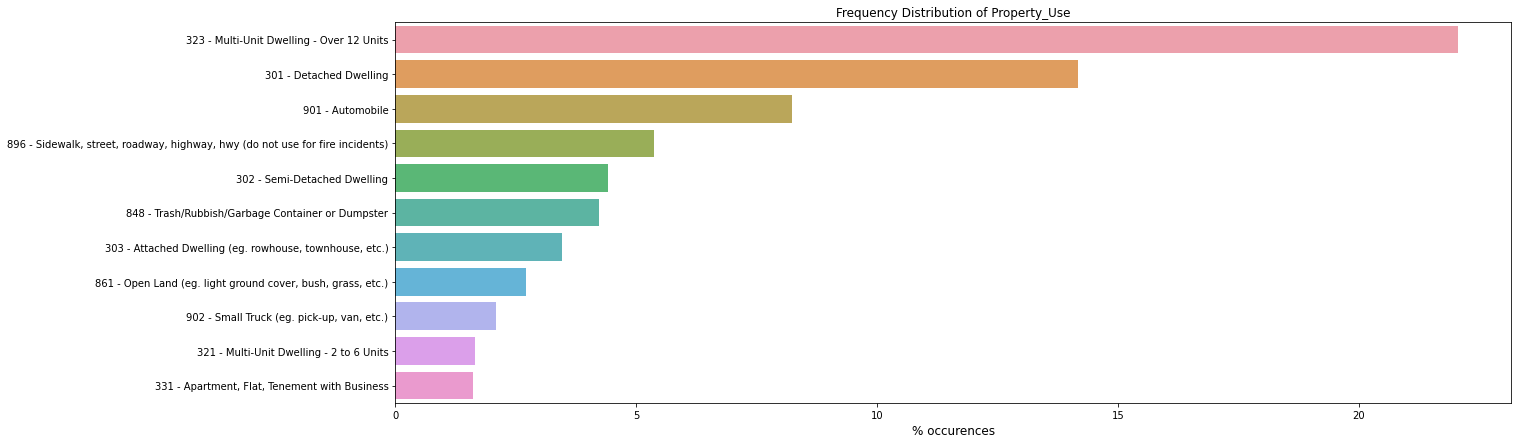

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


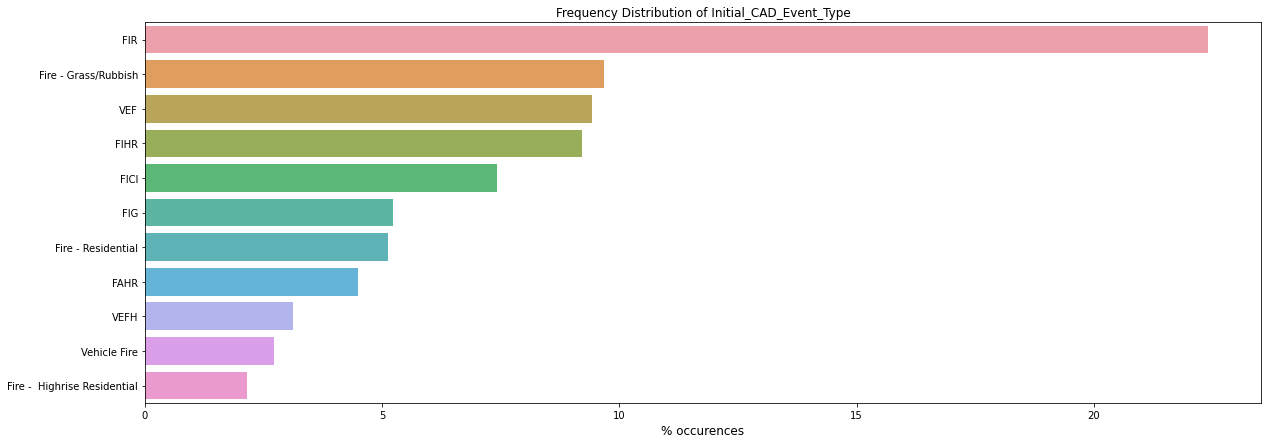

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


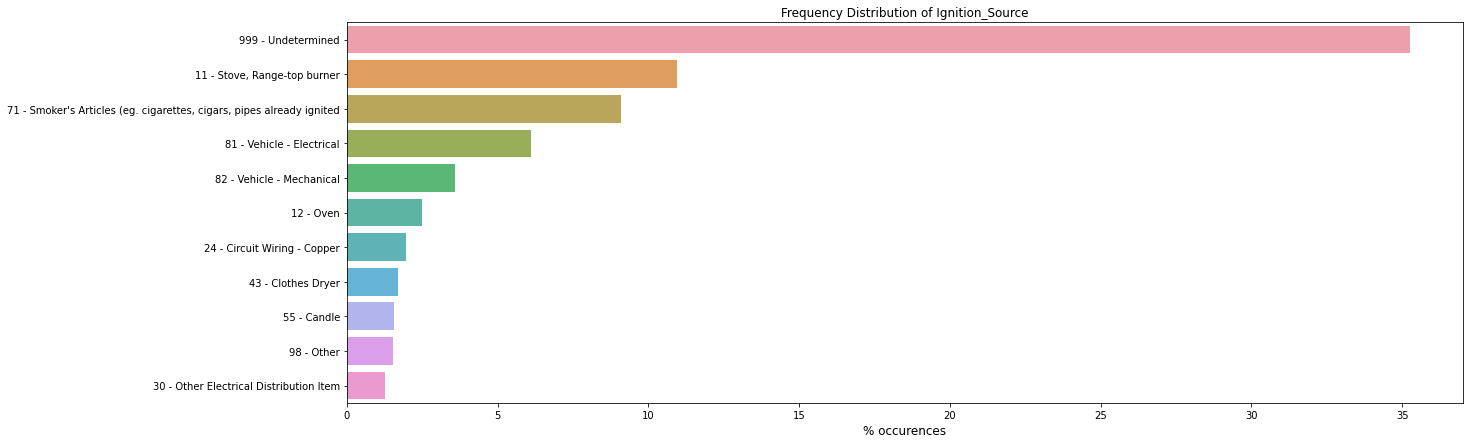

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


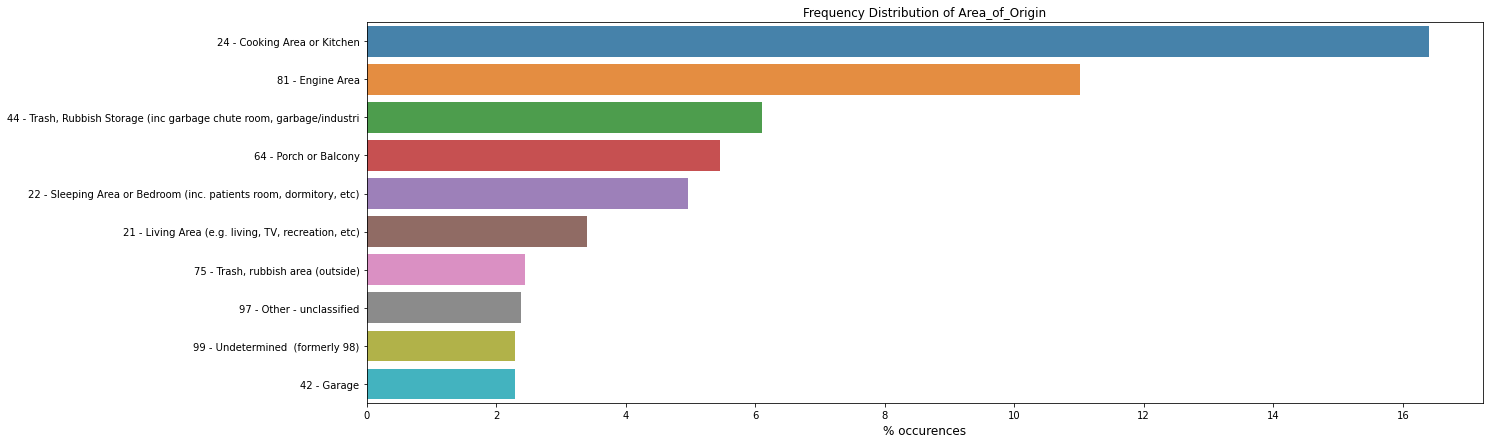

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


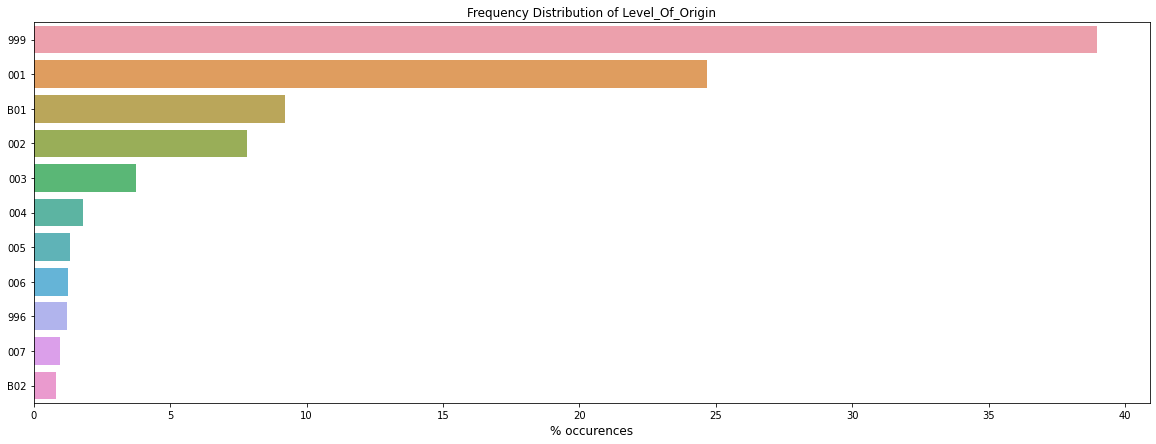

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


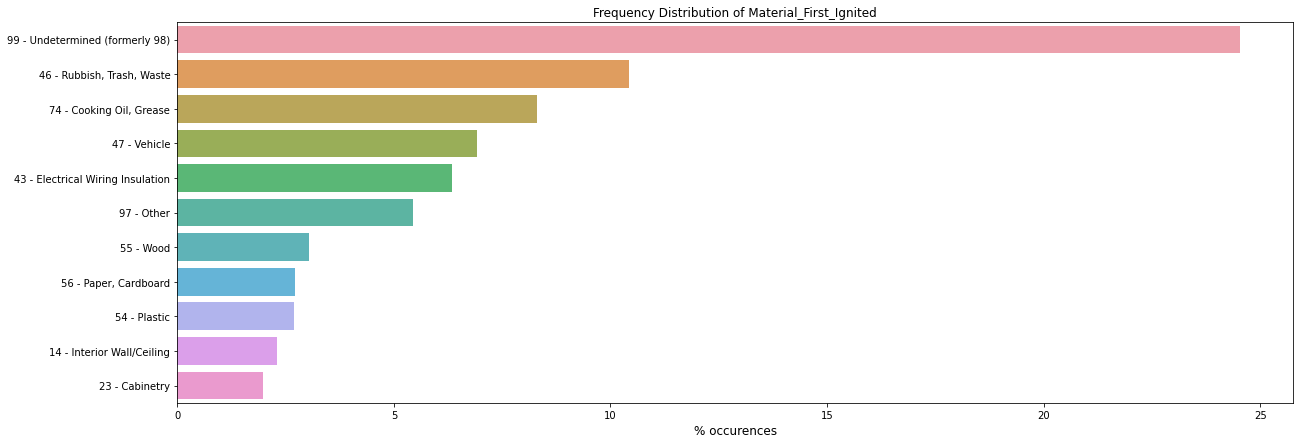

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


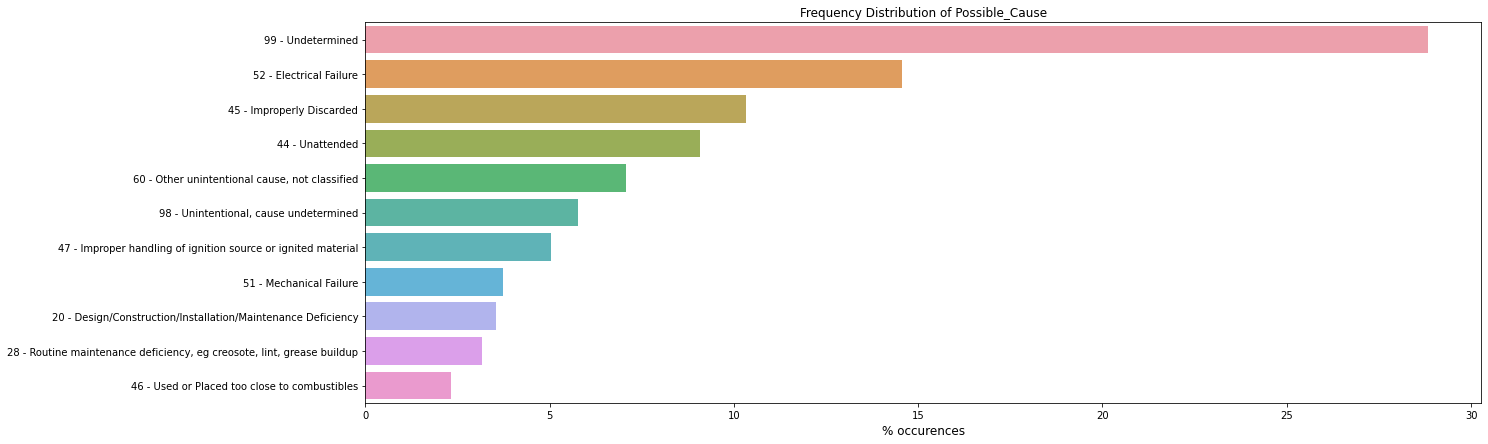

In [53]:
for c in high_cat:
  plot_cat(c)

In [33]:
med_cat=[x for x in med_cat.index if x not in cat_var_id]
for c in med_cat:
  exploration_cat(c)

---------------------------------------
variable name: Extent_Of_Fire 

number of categories:  13 

NaN                                                                                 0.360516
1 - Confined to object of origin                                                    0.292142
2 - Confined to part of room/area of origin                                         0.232892
3 - Spread to entire room of origin                                                 0.027429
4 - Spread beyond room of origin, same floor                                        0.026745
9 - Confined to roof/exterior structure                                             0.019503
7 - Spread to other floors, confined to building                                    0.015625
11 - Spread beyond building of origin, resulted in exposure fire(s)                 0.006843
8 - Entire Structure                                                                0.005646
99 - Undetermined                                              

### High Card: FSA frequency encoding

In [ ]:
#encode FSA with frequency (numerical)
df=freq_encode('FSA')

### High Card: Level of Origin binning


* 001-003 low_rise_level
* 004-012 mid_rise_level
* 012-100 high_rise_level
* 996 roof
* B - below_grade_level
* rest including NaN - other



In [50]:
#Level_of_Origin: https://www.toronto.ca/ext/open_data/catalog/data_set_files/ofmcodes2009.pdf
LOO=df['Level_Of_Origin']

In [51]:
LOO_imputed=[None]*len(LOO)
for i in range(len(LOO)):
  try: 
    #LOO_imputed[i]=int(LOO[i])
    if int(LOO[i])<=3:
      LOO_imputed[i]='low_rise_level'
    elif int(LOO[i])<=12:
      LOO_imputed[i]='mid_rise_level'
    elif int(LOO[i])<=100:
      LOO_imputed[i]='high_rise_level'
    elif int(LOO[i])==996:
      LOO_imputed[i]='roof'
    else:
      LOO_imputed[i]='other'
  except:
    LOO_imputed[i]='below_grade_level'
print(LOO_imputed[0:50])

['other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'other', 'other', 'low_rise_level', 'high_rise_level', 'low_rise_level', 'other', 'other', 'other', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'mid_rise_level', 'other', 'other', 'mid_rise_level', 'other']


In [52]:
df['LOO_imputed']=LOO_imputed

### High Card: Possible Cause


*   evaluate woe for each category
*   create bins based on woe



In [ ]:
df_test=woe_encoder('Possible_Cause','LABEL')

In [ ]:
df_test[['Possible_Cause','Possible_Cause_woe']].drop_duplicates().sort_values(by='Possible_Cause_woe')

,Possible_Cause,Possible_Cause_woe
13,"28 - Routine maintenance deficiency, eg creosote, lint, grease buildup",-1.421197
21,51 - Mechanical Failure,-1.358665
1,03 - Suspected Vandalism,-1.299777
106,49 - Improper Storage,-1.257930
947,73 - Natural Cause,-0.995566
6,20 - Design/Construction/Installation/Maintenance Deficiency,-0.823195
0,99 - Undetermined,-0.610312
58,01 - Suspected Arson,-0.546298
7,52 - Electrical Failure,-0.400887
48,45 - Improperly Discarded,-0.331906


In [ ]:
df_test=woe_encoder('Initial_CAD_Event_Type','LABEL')

In [ ]:
df_test[['Initial_CAD_Event_Type','Initial_CAD_Event_Type_woe']].drop_duplicates().sort_values(by='Initial_CAD_Event_Type_woe')

,Initial_CAD_Event_Type,Initial_CAD_Event_Type_woe
1,Fire - Grass/Rubbish,-3.526908
4834,VEFH,-2.105228
4837,FIG,-2.058633
4832,VEF,-1.882695
0,Vehicle Fire,-1.558351
41,Vehicle Fire - Highway,-1.552002
5019,FITP,-1.223144
4920,FIS,-1.168585
4933,FII,-1.159195
181,Fire - Other,-0.973093


## High Card: Material_First_Ignited

In [23]:
df_test=woe_encoder('Material_First_Ignited','LABEL')
df_test[['Material_First_Ignited','Material_First_Ignited_woe']].drop_duplicates().sort_values(by='Material_First_Ignited_woe')

,Material_First_Ignited,Material_First_Ignited_woe
437,"44 - Creosote (chimney, flue pipe)",-2.199539
26,"46 - Rubbish, Trash, Waste",-1.389719
0,47 - Vehicle,-1.385270
91,"51 - Bush, Grass, Tree, Leaves, etc.",-1.347787
389,"81 - Rubber, not classified above",-1.249347
196,15 - Structural Member,-1.205287
623,"59 - Asphalt, Tar Product",-1.159195
256,11 - Exterior Roof Covering,-0.779343
24,72 - Diesel Fuel/Fuel Oil,-0.744252
71,19 - Other Building Component,-0.722590


## High Card: Ignition_Source

In [24]:
df_test=woe_encoder('Ignition_Source','LABEL')
df_test[['Ignition_Source','Ignition_Source_woe']].drop_duplicates().sort_values(by='Ignition_Source_woe')

,Ignition_Source,Ignition_Source_woe
21,81 - Vehicle - Electrical,-1.671906
15,82 - Vehicle - Mechanical,-1.547214
104,36 - Fireplace - Masonry,-1.205287
130,17 - Wood burning stove,-1.017545
116,20 - Service/Utility Lines (includes power/hydro transmission lines),-1.001106
16,24 - Circuit Wiring - Copper,-0.932508
19,98 - Other,-0.811338
129,"92 - Open Fire (eg. camp fire, rubbish fire, etc.)",-0.744252
192,"93 - Hot Ashes, Embers, Spark",-0.707884
2291,91 - Fireworks,-0.654639


## High Card: Property Use


In [ ]:
#woe doesn't produce meaningful bins
df_test=woe_encoder('Property_Use','LABEL')
df_test[['Property_Use','Property_Use_woe']].drop_duplicates().sort_values(by='Property_Use_woe')

In [ ]:
import re,os
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc,roc_auc_score,f1_score
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

!pip install unidecode
import unidecode

!pip install contractions
import contractions

!pip install swifter
import swifter #https://github.com/jmcarpenter2/swifter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 235 kB 5.1 MB/s 
     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 35.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85447 sha256=26b52f04cedae26000887da5d6569ba80f06d4afb1b2db92dfd30b4f1d7f5a03
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 296 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 50.3 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4

In [ ]:
df[df['Property_Use'].isnull()]

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,TFS_Alarm_Timedemo,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,label
17276,1964205,79 - Other Outside Area,NaN,NaN,0,0,NaN,NaN,NaN,2013-04-17 22:37:00,NaN,01 - Fire,NaN,NaN,NaN,NaN,999 - Undetermined,F13029095,442,11.0,FAHR,Weston Rd / Oak St,2013-04-17 22:46:40,43.70779,NaN,-79.53363,"31 - Mattress, Pillow",1 - Extinguished by fire department,5,18,99 - Undetermined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3 - Fire with smoke showing only - including vehicle, outdoor fires",2013-04-17 22:29:19,2013-04-17 22:35:26,0,71,81,FIRE STATION 442,2015 LAWRENCE AVE W,9796836,34953,9796835,REGULAR,2015,Lawrence Ave W,NaN,Fire/Ambulance Stations,"Land, Structure, Structure Entrance",NaN,"Fire Station 442, Ambulance Station 10",NaN,NaN,NaN,NaN,York South-Weston (5),York,3234576,"{u'type': u'Point', u'coordinates': (-79.5123844109, 43.7005987012)}",-79.512384,43.700599,442,0,13701.458324,2013-04-17 00:00:00,2,0,2013,4,6.117,17,17,22,22,11.233,6,Night,0,0,0,0,2013-04-17,2.32,0.06,0.0,7.515,64.51,17.19,2013-04-17 22:29:19,M9N 3V9,M9N,0,4928.6,0.09292,0.117502,39.3,39.0,0.472981,0


In [ ]:
df_p=df[['Property_Use','label']]

In [ ]:
df_p.shape

(17536, 3)

In [ ]:
[np.where(df_p['Property_Use'].isnull())[0][0]]

[17276]

In [ ]:
df_p=df_p.drop(labels=[np.where(df_p['Property_Use'].isnull())[0][0]],axis=0)

In [ ]:
df_p['Property_Use'].isnull().sum()

0

In [ ]:
# clean text
def clean_text(text):
  # replace all non-printable characters (such as "\n") with space, and replace multiple spaces with single space
  df_p['ss_text']=text.apply(lambda x: ' '.join(c for c in x.split()))
  #expand contraction
  df_p['contract_text']=df_p['ss_text'].apply(lambda x: ' '.join([contractions.fix(w) for w in x.split()]))
  #lower case
  df_p['lower_text']=df_p['contract_text'].apply(lambda x: ' '.join([w.lower() for w in x.split()]))
  #lemmatization
  lmtzr=WordNetLemmatizer()
  df_p['lemm_text']=df_p['lower_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(w) for w in x.split()]))
  #remove punctuation
  df_p['punct_text']=df_p['lemm_text'].str.replace('[^\w\s]',' ')
  #remove english stopwords
  STOPWORDS=set(stopwords.words('english'))
  df_p['stop_text']=df_p['punct_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))
  #remove all numbers
  df_p["text_cleaned"]=df_p['stop_text'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
  #return
  return df_p["text_cleaned"]

In [ ]:
clean_text(df_p['Property_Use'])

0        sidewalk street roadway highway hwy use fire incidents         
1        sidewalk street roadway highway hwy use fire incidents         
2        outdoor general auto parking                                   
3        department store                                               
4        lawn around structure                                          
5        vehicle vehicle part                                           
6        detached dwelling                                              
7        multi unit dwelling unit                                       
8        court facility                                                 
9        automobile                                                     
10       gymnasium                                                      
11       attached dwelling eg rowhouse townhouse etc                    
12       multi unit dwelling unit                                       
13       apartment flat tenement business          

In [ ]:
df_p[df_p['text_cleaned']==""]

,Property_Use,label,ss_text,contract_text,lower_text,lemm_text,punct_text,stop_text,text_cleaned


In [ ]:
word_list=' '.join(df_p['text_cleaned'])
word_listing=str(word_list).split()

In [ ]:
from collections import Counter
c=Counter(word_listing)
sorted_list=sorted(c.items(),key=lambda i:i[1],reverse=True)
top20=sorted_list[0:20]
top20

[('unit', 8618),
 ('dwelling', 8279),
 ('multi', 4373),
 ('detached', 3484),
 ('etc', 1610),
 ('eg', 1579),
 ('automobile', 1444),
 ('fire', 946),
 ('sidewalk', 942),
 ('street', 942),
 ('roadway', 942),
 ('highway', 942),
 ('hwy', 942),
 ('use', 942),
 ('incidents', 942),
 ('semi', 842),
 ('trash', 742),
 ('rubbish', 742),
 ('garbage', 742),
 ('container', 742)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_p["text_cleaned"], df_p["label"], test_size=0.2, random_state=10086, stratify=df_p["label"])
print(X_train.shape)
print(X_test.shape)

(14028,)
(3507,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
pipeline_bow_bg = Pipeline([('vectorizer', CountVectorizer(max_features=1000,ngram_range=(2,3))), ('dtf', DenseTransformer()),('scaler', StandardScaler()), ('LR', LogisticRegression(random_state=2020))])
pipeline_bow_bg.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(2, 3))),
                ('dtf', <__main__.DenseTransformer object at 0x7f318df08190>),
                ('scaler', StandardScaler()),
                ('LR', LogisticRegression(random_state=2020))])

In [ ]:
#accuracy
pipeline_bow_bg.score(X_test,y_test)

0.9432563444539492

In [ ]:
## f1 score
f1_score(y_test,pipeline_bow_bg.predict(X_test))

0.0

In [ ]:
## roc auc score
roc_auc_score(y_test, pipeline_bow_bg.predict_proba(X_test)[:,1])

0.710552460002552

In [ ]:
#coefficients (coef_) of your logisitic regression model, which features are most positively/negatively correlated with toxic comments?
feature_names_bg=pipeline_bow_bg.named_steps['vectorizer'].get_feature_names()

In [ ]:
len(feature_names_bg)

1000

In [ ]:
feature_coeff_bg=pipeline_bow_bg.named_steps['LR'].coef_[0]
bg_feature_df=pd.DataFrame()
bg_feature_df['feature']=feature_names_bg
bg_feature_df['coeff']=feature_coeff_bg
bg_feature_df['abs']=np.abs(feature_coeff_bg)
bg_feature_df.sort_values(by='abs',ascending=False, inplace=True)

In [ ]:
bg_feature_df.head(20)

,feature,coeff,abs
184,detached dwelling,0.887952,0.887952
870,subway station,-0.342435,0.342435
739,school elementary,-0.230320,0.230320
572,multi unit dwelling,0.223743,0.223743
950,unit dwelling,0.223743,0.223743
951,unit dwelling unit,0.223743,0.223743
571,multi unit,0.223743,0.223743
215,dwelling unit,0.223743,0.223743
185,detached dwelling business,-0.195300,0.195300
694,recycling facility,-0.195043,0.195043


In [ ]:
df_p[df_p['Property_Use'].str.contains('Subway')]

##Smoke Alarm

In [25]:
missing_smoke=df[df['Smoke_Alarm_at_Fire_Origin'].isnull()]

In [26]:
missing_smoke.shape

(6322, 59)

In [30]:
#missing
missing_smoke.select_dtypes(include='object').isnull().sum().sort_values()

Material_First_Ignited                                           0   
Property_Use                                                     0   
Possible_Cause                                                   0   
Level_Of_Origin                                                  0   
Initial_CAD_Event_Type                                           0   
Incident_Numberinc_                                              0   
Ignition_Source                                                  0   
FSA                                                              0   
Final_Incident_Type                                              0   
Area_of_Origin                                                   1913
Status_of_Fire_On_Arrival                                        1914
Method_Of_Fire_Control                                           1914
Building_Status                                                  6320
Sprinkler_System_Presence                                        6322
Sprinkler_System_Ope

In [37]:
# these are the variables that are missing together -> consider imputing them using the same strategy?
missing_smoke.select_dtypes(include='object').isnull().sum().nlargest(n=13).index

Index(['Business_Impact', 'Extent_Of_Fire',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Building_Status'],
      dtype='object')

In [43]:
missing_smoke['Property_Use'].value_counts(normalize=True,dropna=False).nlargest(n=20)

901 - Automobile                                                                 0.228251
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.149003
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.117210
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.074976
902 - Small Truck (eg. pick-up, van, etc.)                                       0.057735
898 - Other property non structure not classified                                0.030528
891 - Outdoor general auto parking                                               0.028472
301 - Detached Dwelling                                                          0.026574
903 - Large Truck (Excluding Truck Trailer)                                      0.026099
323 - Multi-Unit Dwelling - Over 12 Units                                        0.023727
837 - Vehicles or Vehicle Parts                                                  0.022303
846 - Hydr

In [44]:
missing_smoke['Material_First_Ignited'].value_counts(normalize=True,dropna=False)

99 - Undetermined (formerly 98)                                 0.499684
47 - Vehicle                                                    0.161025
46 - Rubbish, Trash, Waste                                      0.087156
43 - Electrical Wiring Insulation                               0.055995
97 - Other                                                      0.033059
51 - Bush, Grass, Tree, Leaves, etc.                            0.021987
55 - Wood                                                       0.020247
16 - Insulation                                                 0.015501
71 - Gasoline                                                   0.015343
54 - Plastic                                                    0.012338
96 - Multiple diverse objects ignited                           0.009491
56 - Paper, Cardboard                                           0.008858
41 - Books, Magazines, Newspapers                               0.005853
48 - Multiple Objects or Materials                 

In [45]:
missing_smoke['Possible_Cause'].value_counts(normalize=True,dropna=False)

99 - Undetermined                                                         0.525625
52 - Electrical Failure                                                   0.153274
51 - Mechanical Failure                                                   0.062480
45 - Improperly Discarded                                                 0.056944
98 - Unintentional, cause undetermined                                    0.055837
12 - Vehicle Accident/Collision                                           0.030370
60 - Other unintentional cause, not classified                            0.029737
20 - Design/Construction/Installation/Maintenance Deficiency              0.027681
01 - Suspected Arson                                                      0.012496
47 - Improper handling of ignition source or ignited material             0.011705
28 - Routine maintenance deficiency, eg creosote, lint, grease buildup    0.006011
50 - Other misuse of ignition source/material ignited                     0.005853
44 -